Sti til CSV-file
/Users/oscarolsen/Desktop/Algorithmic Trading/ES_1min_sample.csv

Final Trading Summary
Total Trades Executed: 33
Total Profit from Trading: $290.75
Trade Log:
🚀 BUY 33 @ 6039.50
🎯 TAKE PROFIT LONG 33 @ 6047.00 | Profit: $246.50
📉 SHORT SELL 33 @ 6047.00
🚨 STOP LOSS SHORT 33 @ 6052.00 | Loss: $-166.00
🚀 BUY 33 @ 6052.00
🎯 TAKE PROFIT LONG 33 @ 6059.50 | Profit: $246.50
📉 SHORT SELL 33 @ 6059.75
🚨 STOP LOSS SHORT 33 @ 6063.50 | Loss: $-124.75
🚀 BUY 32 @ 6063.50
🚨 STOP LOSS LONG 32 @ 6059.75 | Loss: $-121.00
🚀 BUY 33 @ 6060.25
🎯 TAKE PROFIT LONG 33 @ 6064.75 | Profit: $147.50
📉 SHORT SELL 32 @ 6063.75
🚨 STOP LOSS SHORT 32 @ 6066.50 | Loss: $-89.00
📉 SHORT SELL 32 @ 6068.25
🎯 TAKE PROFIT SHORT 32 @ 6063.75 | Profit: $143.00
📉 SHORT SELL 32 @ 6063.75
🚨 STOP LOSS SHORT 32 @ 6065.50 | Loss: $-57.00
📉 SHORT SELL 32 @ 6064.50
🚨 STOP LOSS SHORT 32 @ 6066.00 | Loss: $-49.00
📉 SHORT SELL 32 @ 6064.00
🎯 TAKE PROFIT SHORT 32 @ 6061.25 | Profit: $87.00
🚀 BUY 32 @ 6062.50
🎯 TAKE PROFIT LONG 32 @ 6065.50 | Profit: $95.00
📉 SHORT SELL 32 @ 6065.25
🚨 STOP LOSS SHORT 3

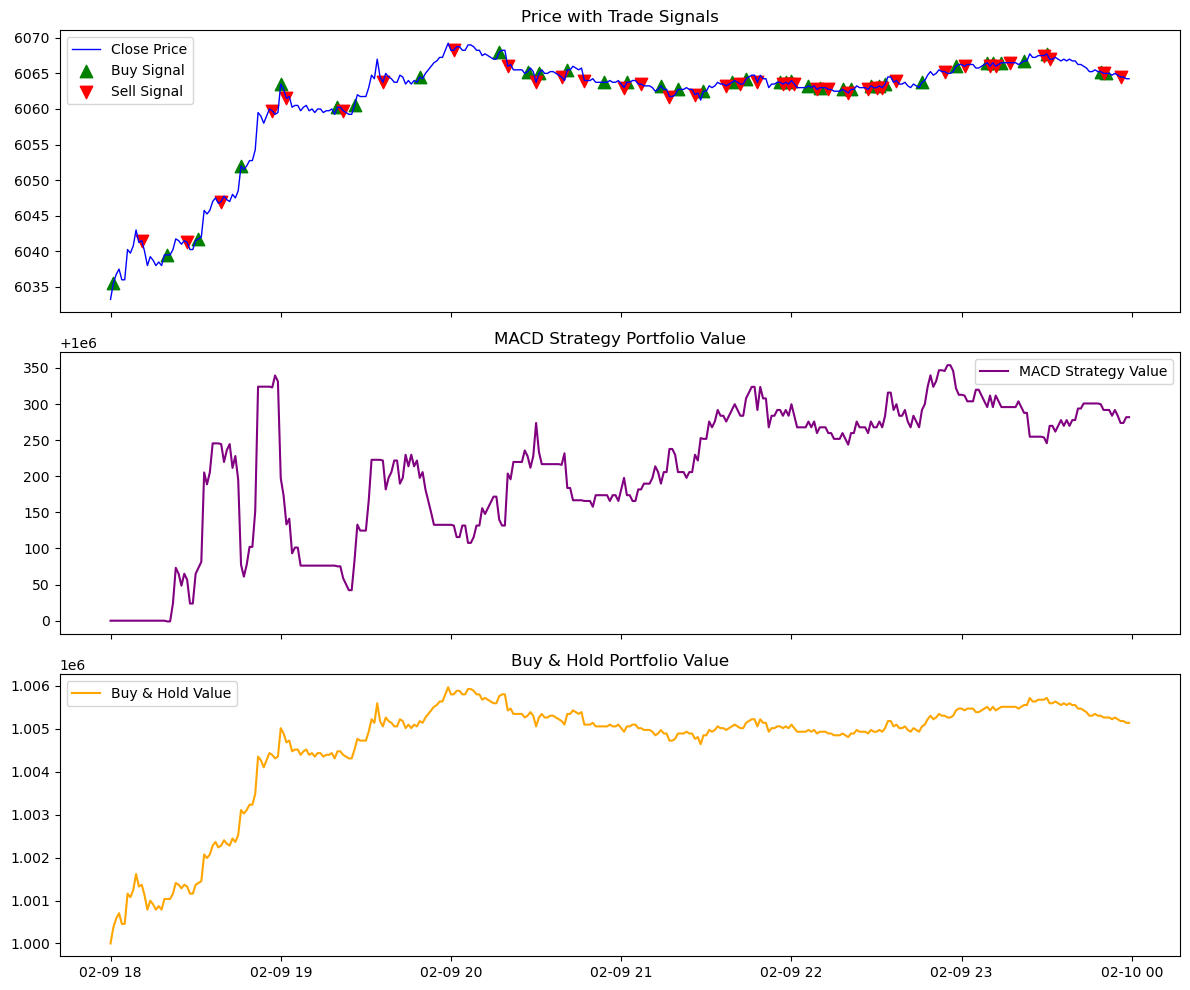

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

# ===== Step 1: Load Data from CSV =====
file_path = "/Users/oscarolsen/Desktop/Algorithmic Trading/ES_1min_sample.csv"  
df = pd.read_csv(file_path)

# Ensure proper datetime formatting and set as index
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# ===== Step 2: Choose a Single Day =====
chosen_date = df.index[0].date()
df_day = df[df.index.date == chosen_date].copy()

# ===== Step 3: Compute ATR for Dynamic Stops =====
df_day['H-L'] = df_day['high'] - df_day['low']
df_day['H-PC'] = (df_day['high'] - df_day['close'].shift(1)).abs()
df_day['L-PC'] = (df_day['low'] - df_day['close'].shift(1)).abs()
df_day['TR'] = df_day[['H-L', 'H-PC', 'L-PC']].max(axis=1)
df_day['ATR'] = df_day['TR'].rolling(window=14).mean()

# ===== Step 4: Apply MACD Trading Strategy =====
best_short_ema, best_long_ema, best_signal = 3, 15, 5  # Best found in optimization
df_day["MACD_Best"] = df_day["close"].ewm(span=best_short_ema, adjust=False).mean() - \
                      df_day["close"].ewm(span=best_long_ema, adjust=False).mean()
df_day["Signal_Best"] = df_day["MACD_Best"].ewm(span=best_signal, adjust=False).mean()

df_day["Position"] = 0
df_day.loc[df_day["MACD_Best"] > df_day["Signal_Best"], "Position"] = 1
df_day.loc[df_day["MACD_Best"] < df_day["Signal_Best"], "Position"] = -1
df_day["Trade_Signal"] = df_day["Position"].diff().replace({2: 1, -2: -1})

# ===== Step 5: Trading Execution with ATR-Based Stops & Trailing Stops =====
initial_cash = 1000000
cash = initial_cash
position = 0
entry_price = None
entry_atr = None
stop_loss_price = None
take_profit_price = None
total_profit = 0
total_transaction_costs = 0
trade_log = []
portfolio_value = []

transaction_cost = 1.00
stop_loss_multiplier = 1.5  # ATR-based stop-loss
take_profit_multiplier = 3.0  # ATR-based take-profit

# Trade sizing function
def calculate_trade_size(price, cash_available):
    max_trade_size = 500
    return min(max_trade_size, int((cash_available * 0.2) / price))

# ===== Trading Logic =====
for i in range(len(df_day)):
    price = df_day["close"].iloc[i]
    signal_val = df_day["Trade_Signal"].iloc[i]
    current_atr = df_day["ATR"].iloc[i]

    # Ensure ATR is available
    if np.isnan(current_atr):
        portfolio_value.append(cash if position == 0 else (cash + position * price))
        continue

    # ===== Stop-Loss / Take-Profit Handling =====
    if position > 0:  # Long position
        if price >= take_profit_price:
            trade_profit = (price - entry_price) * position - transaction_cost
            cash += position * price - transaction_cost
            total_profit += trade_profit
            trade_log.append(f"🎯 TAKE PROFIT LONG {position} @ {price:.2f} | Profit: ${trade_profit:.2f}")
            position = 0
            entry_price = None
        elif price <= stop_loss_price:
            trade_profit = (price - entry_price) * position - transaction_cost
            cash += position * price - transaction_cost
            total_profit += trade_profit
            trade_log.append(f"🚨 STOP LOSS LONG {position} @ {price:.2f} | Loss: ${trade_profit:.2f}")
            position = 0
            entry_price = None

    elif position < 0:  # Short position
        if price <= take_profit_price:
            trade_profit = (entry_price - price) * abs(position) - transaction_cost
            cash -= price * abs(position) + transaction_cost
            total_profit += trade_profit
            trade_log.append(f"🎯 TAKE PROFIT SHORT {abs(position)} @ {price:.2f} | Profit: ${trade_profit:.2f}")
            position = 0
            entry_price = None
        elif price >= stop_loss_price:
            trade_profit = (entry_price - price) * abs(position) - transaction_cost
            cash -= price * abs(position) + transaction_cost
            total_profit += trade_profit
            trade_log.append(f"🚨 STOP LOSS SHORT {abs(position)} @ {price:.2f} | Loss: ${trade_profit:.2f}")
            position = 0
            entry_price = None

    # ===== New Trades Based on MACD Signals =====
    if signal_val == 1 and position == 0:  # Buy signal
        shares = calculate_trade_size(price, cash)
        if shares > 0:
            cash -= shares * price + transaction_cost
            entry_price = price
            position = shares
            stop_loss_price = entry_price - stop_loss_multiplier * current_atr
            take_profit_price = entry_price + take_profit_multiplier * current_atr
            trade_log.append(f"🚀 BUY {shares} @ {price:.2f}")

    elif signal_val == -1 and position == 0:  # Short sell signal
        shares = calculate_trade_size(price, cash)
        if shares > 0:
            cash += shares * price - transaction_cost
            entry_price = price
            position = -shares
            stop_loss_price = entry_price + stop_loss_multiplier * current_atr
            take_profit_price = entry_price - take_profit_multiplier * current_atr
            trade_log.append(f"📉 SHORT SELL {shares} @ {price:.2f}")

    portfolio_value.append(cash if position == 0 else (cash + position * price))

# ===== Step 6: Print Results =====
print("="*60)
print("Final Trading Summary")
print("="*60)
print(f"Total Trades Executed: {len(trade_log)}")
print(f"Total Profit from Trading: ${total_profit:,.2f}")
print("="*60)
print("Trade Log:")
for log in trade_log:
    print(log)

# ===== Step 7: Visualize the Results =====
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Ensure portfolio value and buy & hold benchmark are correctly assigned
df_day["MACD_Strategy_Value"] = portfolio_value
df_day["Buy_Hold_Value"] = initial_cash * (df_day["close"] / df_day["close"].iloc[0])

# Subplot 1: Price with Trade Signals
axs[0].plot(df_day.index, df_day["close"], label="Close Price", color="blue", linewidth=1)
buy_signals = df_day[df_day["Trade_Signal"] == 1]
sell_signals = df_day[df_day["Trade_Signal"] == -1]
axs[0].scatter(buy_signals.index, buy_signals["close"], marker="^", color="green", s=80, label="Buy Signal")
axs[0].scatter(sell_signals.index, sell_signals["close"], marker="v", color="red", s=80, label="Sell Signal")
axs[0].set_title("Price with Trade Signals")
axs[0].legend()

# Subplot 2: MACD Strategy Portfolio Value
axs[1].plot(df_day.index, df_day["MACD_Strategy_Value"], label="MACD Strategy Value", color="purple")
axs[1].set_title("MACD Strategy Portfolio Value")
axs[1].legend()

# Subplot 3: Buy & Hold Benchmark
axs[2].plot(df_day.index, df_day["Buy_Hold_Value"], label="Buy & Hold Value", color="orange")
axs[2].set_title("Buy & Hold Portfolio Value")
axs[2].legend()

plt.tight_layout()
plt.show()